## Analyzing a time-series of Sentinel-2 NDVI values characterizing agricultural plots 🛰️⌚🥕

#### Goal: 
perform a set of geospatial analyses for selected agricultural plots located in Switzerland

#### Data:
- 16 Sentinel-2 images' parts (bands: 'B02', 'B04', 'B08', 'B06' and 'B11'), acquired over Switzerland in 2020 saved in a .zarr format
- agricultural plots with a landuse attribute, saved in a .gpkg format
- checksum file 

#### Research area & time: 
Selected agricultural plots in Switzerland, year of 2022

#### Processing steps:
1. Initial preparation - integrity check
2. Packages import
3. STAC cataloge building
4. Data retrieval via catalogue
5. Raster processing
6. Vector/raster intersection
7. Time-series processing
8. CRS transformation

Prepared by: Aleksandra Radecka <br/>
e-mail: aleksandraradecka@protonmail.com

## 1. Initial preparation
- Performing the integrity check of the obtained file (using previously prepared set of functions saved as *md5_utils.py*)

In [1]:
from md5_utils import extract_info, compute_md5hash, compare_md5hashes

In [2]:
org_md5hash, f_name = extract_info(file_path = 'eogis.7z.md5')

In [4]:
compare_md5hashes(file_path = f_name, original_md5hash = org_md5hash)

The computed and original md5 hash values are the same
The hash value is: 'e648c1ae0d2c2ba3a5e67d70b8bf3d4d'


- Extracting contents of the file

In [5]:
import py7zr

In [6]:
with py7zr.SevenZipFile(f_name, mode='r') as z:
    z.extractall(path = f_name.split('.')[0])

## 2. Packages import

In [7]:
import os

import dask
from dask.distributed import LocalCluster
import geopandas as gpd
import numpy as np
import pandas as pd
from pyproj import CRS, Proj, Transformer
import pystac
import rasterio 
import rioxarray as rio
from scipy.signal import savgol_filter
from shapely.geometry import Polygon, Point, mapping, box
import xarray as xr
import zarr

## 3. STAC cataloge building
* Load the data in the zarr store and generate a local STAC catalogue. 
* Calculate the maximum percentage (max over all bands) of missing data per time-stamp and add as attribute to each asset in the catalogue.

In [8]:
# loading data from a zarr store
s2_ds = xr.open_zarr("eogis/eoml_preds.zarr", decode_coords = "all")

In [9]:
s2_ds

<xarray.Dataset>
Dimensions:      (band: 5, time: 16, y: 735, x: 1049)
Coordinates:
  * band         (band) <U8 'B02' 'B04' 'B08' 'B06' 'B11'
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2020-03-19 2020-04-05 ... 2020-09-20
  * x            (x) float64 4.226e+05 4.226e+05 ... 4.331e+05 4.331e+05
  * y            (y) float64 5.345e+06 5.345e+06 ... 5.338e+06 5.338e+06
Data variables:
    s2_ts        (time, band, y, x) float64 dask.array<chunksize=(2, 2, 184, 263), meta=np.ndarray>

In [10]:
# creating a STAC catalog
catalog = pystac.Catalog(id = "s2-catalog", description = "The catalog of Sentinel-2 imagery.")

In [11]:
# discovering acquisition times and bands 
s2_ds.coords['band'].to_numpy(), s2_ds.coords['time'].to_numpy()

(array(['B02', 'B04', 'B08', 'B06', 'B11'], dtype='<U8'),
 array(['2020-03-19T00:00:00.000000000', '2020-04-05T00:00:00.000000000',
        '2020-04-08T00:00:00.000000000', '2020-04-23T00:00:00.000000000',
        '2020-05-18T00:00:00.000000000', '2020-06-12T00:00:00.000000000',
        '2020-06-27T00:00:00.000000000', '2020-08-01T00:00:00.000000000',
        '2020-08-08T00:00:00.000000000', '2020-08-21T00:00:00.000000000',
        '2020-08-23T00:00:00.000000000', '2020-08-26T00:00:00.000000000',
        '2020-09-02T00:00:00.000000000', '2020-09-05T00:00:00.000000000',
        '2020-09-15T00:00:00.000000000', '2020-09-20T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [12]:
# function creating bbox and geometry for a raster (source: [1])
def get_bbox_and_footprint(raster_uri):
    with rasterio.open(raster_uri) as ds:
        bounds = ds.bounds
        bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
        footprint = Polygon(
            [
                [bounds.left, bounds.bottom],
                [bounds.left, bounds.top],
                [bounds.right, bounds.top],
                [bounds.right, bounds.bottom],
            ]
        )

        return (bbox, mapping(footprint))

In [13]:
# creating a data folder in a current directory
folder_name = 's2_imagery'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [14]:
# iteration over acquisiton dates
for time in s2_ds.time:
    # extracting single timestamps
    item_time = pd.Timestamp(time.item())
    # creating item ID
    item_id = "s2_" + str(item_time.date()).replace("-", "_")
    # extracting single ds
    s2_time_ds = s2_ds.sel(time=time)
    # calculating max percentage of missing data
    s2_time_da = s2_time_ds['s2_ts']
    item_perc = max([s2_time_da.sel(band=bx).isnull().sum() / s2_time_da.sel(band=bx).size * 100 for bx in s2_time_da.coords['band'].to_numpy()]).compute().item()
    # export single bands as GeoTIFFs
    band_dict = {}
    for band in s2_time_da.band:
        s2_time_band_da = s2_time_da.sel(band=band)
        asset_id = item_id + "_" + band.item()
        asset_path = os.path.join(folder_name, asset_id + ".tif")
        band_dict[asset_id] = asset_path
        s2_time_band_da.rio.to_raster(asset_path)
    # computing bbox & footprint of the first band
    item_bbox, item_footprint = get_bbox_and_footprint(list(band_dict.values())[0])
    # creating a STAC Item
    item = pystac.Item(
        id = item_id,
        geometry = item_footprint,
        bbox = item_bbox,
        datetime = item_time,
        properties = {"missing_data": item_perc},
    )
    # adding an item to catalog
    catalog.add_item(item)
    # adding assets > bands to item
    for as_id in band_dict:
        item.add_asset(
            key=as_id, asset=pystac.Asset(href=band_dict[as_id], media_type=pystac.MediaType.GEOTIFF) 
        )

In [15]:
# setting links 
catalog.normalize_hrefs(os.path.join(folder_name, "stac"))

In [16]:
# saving catalog
catalog.save(catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [17]:
# viewing catalog
with open(catalog.self_href) as f:
    print(f.read())

{
  "type": "Catalog",
  "id": "s2-catalog",
  "stac_version": "1.0.0",
  "description": "The catalog of Sentinel-2 imagery stored by TLG.",
  "links": [
    {
      "rel": "root",
      "href": "./catalog.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./s2_2020_03_19/s2_2020_03_19.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./s2_2020_04_05/s2_2020_04_05.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./s2_2020_04_08/s2_2020_04_08.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./s2_2020_04_23/s2_2020_04_23.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./s2_2020_05_18/s2_2020_05_18.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      "href": "./s2_2020_06_12/s2_2020_06_12.json",
      "type": "application/json"
    },
    {
      "rel": "item",
      

In [18]:
# viewing last item
with open(item.self_href) as f:
    print(f.read())

{
  "type": "Feature",
  "stac_version": "1.0.0",
  "id": "s2_2020_09_20",
  "properties": {
    "missing_data": 3.5935747034752894,
    "datetime": "2020-09-20T00:00:00Z"
  },
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          422635.0,
          5337815.0
        ],
        [
          422635.0,
          5345165.0
        ],
        [
          433125.0,
          5345165.0
        ],
        [
          433125.0,
          5337815.0
        ],
        [
          422635.0,
          5337815.0
        ]
      ]
    ]
  },
  "links": [
    {
      "rel": "root",
      "href": "../catalog.json",
      "type": "application/json"
    },
    {
      "rel": "parent",
      "href": "../catalog.json",
      "type": "application/json"
    }
  ],
  "assets": {
    "s2_2020_09_20_B02": {
      "href": "s2_imagery/s2_2020_09_20_B02.tif",
      "type": "image/tiff; application=geotiff"
    },
    "s2_2020_09_20_B04": {
      "href": "s2_imagery/s2_2020_09_20_

#### Comments:
- <u>Item documentation:</u> Sentinel-2 items should be better documented in order to facilitate future queries. I didn't have the Sentinel-2's metadata XML files so I skipped this. 
- <u>Item ID:</u> Ideally the official Sentinel-2 granule's ID should be used as Item's ID. I decided to use the acquisition date to build items' IDs as this was a unique element of each Item. 
- <u>Raster data format:</u> I decided to choose GeoTIFF as a format for saving Assets because the documentation stated that *"GeoTIFF and COG ... reflect the community consensus direction"* [2]. In general I belive that saving each band in NetCDF4 format would be a better choice. It would allow to concatenate single bands into an Xarray cube easily. Performing this task with GeoTIFFs is not so straightforward (as can be observed in the code below). Additionally, if it turned out that the data is needed in a GeoTIFF format, it is easy to transform a NetCDF4 file into a GeoTIFF file. Another part of STAC's documentation stated however that *"registered Media Types are preferred"*[3]. NetCDF4 is not on the list. 
- <u>EO extension & missing data:</u> Looking through documentation later I discovered that STAC offers EO extension [8] that allows to describe spectral bands more precisely. I also noticed that the missing_value characterizing an Item should have been added to each Item's Asset, not Item. Both issues are TODO. 

## 4. Data retrieval via catalogue
* Demonstrate how the catalogue can be queried from python to import into a xarray.DataArray with the following conditions met:
    * bands: `["B04", "B08"]`
    * data_completeness: >=80
    * time_slice: `["2020-04-01","2020-08-01"]`
    * crop extent:  `[14.0, 48.21, 14.06, 48.23]`

In [19]:
s2_items = catalog.get_items()

In [20]:
# filtering Items by time_slice and data_completeness
filtered_items = [item for item in s2_items if (pd.Timestamp("2020-04-01") <= item.datetime <= pd.Timestamp("2020-08-01")) \
                  & (100 - item.properties['missing_data'] >= 80)]

In [21]:
# filtering Assets by band
filtered_assets = {}

for item in filtered_items:
    for as_key in list(item.assets.keys()):
        if "B04" in as_key or "B08" in as_key:
            filtered_assets[as_key] = item.assets[as_key].href

In [22]:
filtered_assets

{'s2_2020_04_05_B04': 's2_imagery/s2_2020_04_05_B04.tif',
 's2_2020_04_05_B08': 's2_imagery/s2_2020_04_05_B08.tif',
 's2_2020_04_08_B04': 's2_imagery/s2_2020_04_08_B04.tif',
 's2_2020_04_08_B08': 's2_imagery/s2_2020_04_08_B08.tif',
 's2_2020_04_23_B04': 's2_imagery/s2_2020_04_23_B04.tif',
 's2_2020_04_23_B08': 's2_imagery/s2_2020_04_23_B08.tif',
 's2_2020_05_18_B04': 's2_imagery/s2_2020_05_18_B04.tif',
 's2_2020_05_18_B08': 's2_imagery/s2_2020_05_18_B08.tif',
 's2_2020_06_12_B04': 's2_imagery/s2_2020_06_12_B04.tif',
 's2_2020_06_12_B08': 's2_imagery/s2_2020_06_12_B08.tif',
 's2_2020_06_27_B04': 's2_imagery/s2_2020_06_27_B04.tif',
 's2_2020_06_27_B08': 's2_imagery/s2_2020_06_27_B08.tif',
 's2_2020_08_01_B04': 's2_imagery/s2_2020_08_01_B04.tif',
 's2_2020_08_01_B08': 's2_imagery/s2_2020_08_01_B08.tif'}

In [23]:
# creating xr.DataArray from each filtered asset
asset_dataarrays = []

for as_key in filtered_assets:
    # gathering info
    asset_path = filtered_assets[as_key]
    asset_band = as_key.split("_")[-1]
    asset_time = pd.Timestamp("-".join(as_key.split("_")[1:4]))
    # creating xr.DataArray 
    asset_da = rio.open_rasterio(asset_path)
    asset_da = asset_da.rio.reproject(CRS('EPSG:4326'))
    asset_da = asset_da.rename({"x":"lon"})
    asset_da = asset_da.rename({"y":"lat"})
    asset_da.name = "s2_ts"
    asset_da.coords['band'] = [asset_band]
    asset_da = asset_da.assign_coords({"time":asset_time})
    asset_dataarrays.append(asset_da)

In [24]:
# dividing list elements into pairs - B04 & B08 from the same time
nested_asset_dataarrays = [[asset_dataarrays[i], asset_dataarrays[i + 1]] for i in range(0, len(asset_dataarrays) - 1, 2)]

In [25]:
# creating one xr.DataArray from all filtered assets
query_dataarray = xr.combine_nested(nested_asset_dataarrays, concat_dim=["time", "band"])

In [26]:
query_dataarray

<xarray.DataArray 's2_ts' (time: 7, band: 2, lat: 551, lon: 1166)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lon          (lon) float64 13.96 13.96 13.96 13.96 ... 14.1 14.1 14.1 14.1
  * lat          (lat) float64 48.26 48.26 48.26 48.26 ... 48.19 48.19 48.19
  * band         (band) <U3 'B04' 'B08'
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-04-05 2020-04-08 ... 2020-08-01

In [27]:
# limiting query xr.DataArray to the crop_extent
query_dataarray = query_dataarray.sel(lon = slice(14.0, 14.06), lat = slice(48.23, 48.21))

In [28]:
query_dataarray

<xarray.DataArray 's2_ts' (time: 7, band: 2, lat: 164, lon: 491)>
array([[[[0.1882, 0.1842, 0.1792, ..., 0.0959, 0.0976, 0.085 ],
         [0.185 , 0.1788, 0.1738, ..., 0.1222, 0.123 , 0.1038],
         [0.186 , 0.1802, 0.1814, ..., 0.123 , 0.1278, 0.1202],
         ...,
         [0.1334, 0.1258, 0.1266, ..., 0.0579, 0.0579, 0.0583],
         [0.1384, 0.1308, 0.1268, ..., 0.065 , 0.065 , 0.0661],
         [0.1348, 0.1292, 0.1288, ..., 0.0658, 0.0678, 0.0729]],

        [[0.2398, 0.2311, 0.2322, ..., 0.4001, 0.4174, 0.424 ],
         [0.2315, 0.2238, 0.2242, ..., 0.3608, 0.3826, 0.3896],
         [0.2359, 0.2279, 0.232 , ..., 0.3725, 0.393 , 0.4025],
         ...,
         [0.2039, 0.2039, 0.2015, ..., 0.4006, 0.4006, 0.385 ],
         [0.2106, 0.2047, 0.1996, ..., 0.3549, 0.3549, 0.3488],
         [0.2154, 0.2095, 0.2054, ..., 0.3757, 0.3708, 0.3602]]],


       [[[0.1738, 0.1686, 0.1636, ..., 0.0867, 0.0777, 0.0685],
         [0.1706, 0.1626, 0.1638, ..., 0.1024, 0.0956, 0.0866],
         [0.1698, 0.1638, 0.167 , ..., 0.1016, 0.1004, 0.0943],
...
         [0.582 , 0.5756, 0.6   , ..., 0.3208, 0.3208, 0.305 ],
         [0.5796, 0.578 , 0.5972, ..., 0.283 , 0.283 , 0.2614],
         [0.602 , 0.5688, 0.5536, ..., 0.2918, 0.2888, 0.279 ]]],


       [[[0.0224, 0.0221, 0.0262, ..., 0.0711, 0.0766, 0.0955],
         [0.0217, 0.023 , 0.0252, ..., 0.158 , 0.1648, 0.092 ],
         [0.0211, 0.0223, 0.0247, ..., 0.1818, 0.1842, 0.1156],
         ...,
         [0.019 , 0.0195, 0.019 , ..., 0.2514, 0.2514, 0.2508],
         [0.0196, 0.0197, 0.0198, ..., 0.2326, 0.2326, 0.2238],
         [0.0189, 0.0198, 0.0203, ..., 0.2028, 0.1924, 0.1928]],

        [[0.5536, 0.5528, 0.5412, ..., 0.3774, 0.366 , 0.3472],
         [0.5556, 0.5556, 0.5488, ..., 0.4416, 0.3848, 0.3408],
         [0.5628, 0.5624, 0.5624, ..., 0.4492, 0.389 , 0.362 ],
         ...,
         [0.5392, 0.5448, 0.548 , ..., 0.376 , 0.376 , 0.3696],
         [0.5436, 0.5436, 0.5464, ..., 0.3504, 0.3504, 0.3416],
         [0.5492, 0.5512, 0.5508, ..., 0.3208, 0.3152, 0.31  ]]]])
Coordinates:
  * lon          (lon) float64 14.0 14.0 14.0 14.0 ... 14.06 14.06 14.06 14.06
  * lat          (lat) float64 48.23 48.23 48.23 48.23 ... 48.21 48.21 48.21
  * band         (band) <U3 'B04' 'B08'
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-04-05 2020-04-08 ... 2020-08-01

#### Comments:
- <u>Additional tools:</u> STAC ecosystem includes a number of additional tools [4] that can help to create STAC Catalogs/Collections/Items faster (e.g. xstac for Xarray Datasets [5]) or perform queries on this objects more easily (e.g. EODAG [6]). My experiences from previous projects suggest that these solutions are however not stable yet. In order to omit potential problems, I decided to code everything more manually. If similar procedures are to be performed often, it is definitely recommended to explore the mentioned tools in more detail.
- <u>Asset properties:</u> Variables *asset_band* and *asset_time* in the code above could have been defined in a smarter way. Band name would most probably be available directly if one used STAC EO extension mentioned above. Time could be accessed through a method similar to Item's *get_parent()*, but it seems a similar method for Asset is not yet implemented [9].
- <u>Crop extent query:</u> I intentionally performed the crop after importing data into an Xarray DataArray. The provided coordinates could potentialy be used to query STAC Items (using their bboxes or geometries) in order to check what is the relationship between their spatial extent and area defined by coordinates. As STAC Catalogs/Collections/Items are just metadata elements, the crop itself can only be made on the files whose hrefs were retrieved.

## 5. Raster processing
* Setup a local dask cluster with 4 cores and calculate the NDVI in parallel

In [29]:
# transforming standard xr.DataArray to dask DataArray with original proportion of 1:4 for lat and lon 
dask_dataarray = query_dataarray.chunk({'time':2, 'band':2, 'lat':41, 'lon':123})

In [30]:
dask_dataarray.data

dask.array<xarray-<this-array>, shape=(7, 2, 164, 491), dtype=float64, chunksize=(2, 2, 41, 123), chunktype=numpy.ndarray>

In [31]:
# creating a local cluster 
cluster = LocalCluster(n_workers=4)

In [32]:
def calculate_ndvi(dataarray):
    nir = dataarray.sel(band = "B08")
    red = dataarray.sel(band = "B04")
    return((nir - red) / (nir + red))

In [33]:
# calculating NDVI with the result being an xr.DataArray
ndvi_dataarray = calculate_ndvi(dataarray = dask_dataarray)
ndvi_dataarray_cp = ndvi_dataarray.compute()
ndvi_dataarray_cp = ndvi_dataarray_cp.persist()

In [34]:
cluster.close()

## 6. Vector/raster intersection
* Load the field geometries in the provided geopackage
* For each geometry which overlaps with the NDVI stack extract the underlying NDVI data, and calculate the weighted average per polygon. 
Weighting should be based on the percentage coverage of each pixel, i.e. a pixel falling only to 40% into the polygon should be downweighted accordingly when calculating the mean.

In [35]:
# creating Shapely polygons describing geometry of each pixel in NDVI raster (using the first Timestamp)
ndvi_0_time_da = ndvi_dataarray_cp.isel(time = 0)

In [36]:
ndvi_0_time_df = ndvi_0_time_da.to_dataframe()

In [37]:
ndvi_0_time_df.reset_index(inplace=True)

In [38]:
ndvi_0_time_df.head()

,lat,lon,spatial_ref,time,s2_ts
0,48.229948,14.000073,0,2020-04-05,0.120561
1,48.229948,14.000195,0,2020-04-05,0.112930
2,48.229948,14.000318,0,2020-04-05,0.128828
3,48.229948,14.000440,0,2020-04-05,0.150737
4,48.229948,14.000562,0,2020-04-05,0.311126


In [39]:
ndvi_0_time_df = ndvi_0_time_df[['lat', 'lon']]

In [40]:
latitudes, longitudes = ndvi_0_time_da.coords['lat'].values, ndvi_0_time_da.coords['lon'].values # centroids

In [41]:
polygons = []

In [42]:
lat_step = latitudes[0] - latitudes[1]
lon_step = longitudes[1] - longitudes[0]

In [43]:
lat_step, lon_step 

(0.00012222976047127077, 0.00012222976047304712)

In [44]:
for lat in latitudes:
    for lon in longitudes:
        polygons.append(box(lon-0.5*lon_step, lat-0.5*lat_step, lon+0.5*lon_step, lat+0.5*lat_step))

In [45]:
# creating a dict containg polygon geometries and NDVI values for each Timestamp
content_dict = {'geometry': polygons}

In [46]:
for time in ndvi_dataarray_cp.time:
    ndvi_x_time_da = ndvi_dataarray_cp.sel(time=time)
    ndvi_x_time_df = ndvi_x_time_da.to_dataframe()
    content_dict["ndvi_" + str(pd.Timestamp(time.item()).date()).replace("-", "_")] = ndvi_x_time_df['s2_ts'].to_list()

In [47]:
print(content_dict.keys())

dict_keys(['geometry', 'ndvi_2020_04_05', 'ndvi_2020_04_08', 'ndvi_2020_04_23', 'ndvi_2020_05_18', 'ndvi_2020_06_12', 'ndvi_2020_06_27', 'ndvi_2020_08_01'])


In [48]:
ndvi_polygons_gdf = gpd.GeoDataFrame(content_dict)

In [49]:
ndvi_polygons_gdf.crs = "EPSG:4326"

In [50]:
ndvi_polygons_gdf.head()

,geometry,ndvi_2020_04_05,ndvi_2020_04_08,ndvi_2020_04_23,ndvi_2020_05_18,ndvi_2020_06_12,ndvi_2020_06_27,ndvi_2020_08_01
0,"POLYGON ((14.00013 48.22989, 14.00013 48.23001...",0.120561,0.112360,0.116258,0.147346,0.575342,0.780857,0.922222
1,"POLYGON ((14.00026 48.22989, 14.00026 48.23001...",0.112930,0.118201,0.133547,0.154522,0.571165,0.781547,0.923117
2,"POLYGON ((14.00038 48.22989, 14.00038 48.23001...",0.128828,0.128860,0.135084,0.162624,0.566166,0.793631,0.907649
3,"POLYGON ((14.00050 48.22989, 14.00050 48.23001...",0.150737,0.125581,0.169492,0.195772,0.591743,0.766408,0.850746
4,"POLYGON ((14.00062 48.22989, 14.00062 48.23001...",0.311126,0.350805,0.412025,0.446078,0.758729,0.779154,0.429891


In [51]:
# reading croptypes file and adding column ID (index) to each polygon (each polygon is treated as a separate zone)
croptypes_path = 'eogis/eoml_response_croptypes.gpkg'

In [52]:
croptypes_gdf = gpd.read_file(croptypes_path)

In [53]:
croptypes_gdf.reset_index(inplace=True)

In [54]:
croptypes_gdf.head()

,index,landuse,geometry
0,0,SONSTIGE ACKERFLÄCHEN,"POLYGON ((13.96703 48.19236, 13.96709 48.19237..."
1,1,WINTERGERSTE,"POLYGON ((14.06639 48.19583, 14.06640 48.19575..."
2,2,GRÜNBRACHE,"POLYGON ((14.00121 48.23825, 14.00118 48.23815..."
3,3,WINTERGERSTE,"POLYGON ((14.04966 48.18880, 14.05015 48.18898..."
4,4,KÖRNERMAIS,"POLYGON ((14.00735 48.24179, 14.01297 48.24261..."


In [55]:
# performing intersection between ndvi_polygons gpd.DataFrame and croptypes gpd.DataFrame
intersection = ndvi_polygons_gdf.overlay(croptypes_gdf, how='intersection')

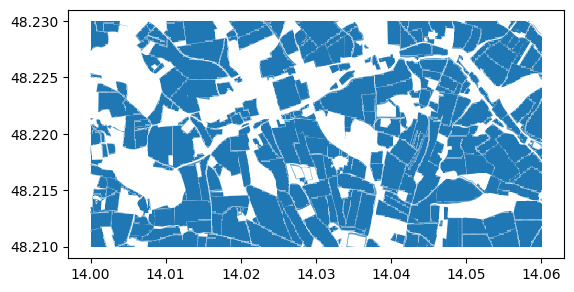

In [56]:
intersection.plot();

In [57]:
zoom_bbox = (14.02, 48.215, 14.03, 48.220)

In [58]:
zoom_intersection = intersection.cx[zoom_bbox[0]:zoom_bbox[2], zoom_bbox[1]:zoom_bbox[3]]

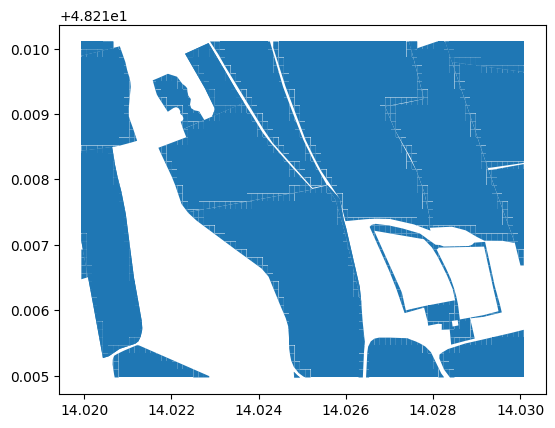

In [59]:
zoom_intersection.plot();

In [60]:
intersection.head()

,ndvi_2020_04_05,ndvi_2020_04_08,ndvi_2020_04_23,ndvi_2020_05_18,ndvi_2020_06_12,ndvi_2020_06_27,ndvi_2020_08_01,index,landuse,geometry
0,0.120561,0.112360,0.116258,0.147346,0.575342,0.780857,0.922222,2829,WINTERWEICHWEIZEN,"POLYGON ((14.00001 48.22989, 14.00001 48.23001..."
1,0.112930,0.118201,0.133547,0.154522,0.571165,0.781547,0.923117,2829,WINTERWEICHWEIZEN,"POLYGON ((14.00013 48.22989, 14.00013 48.23001..."
2,0.128828,0.128860,0.135084,0.162624,0.566166,0.793631,0.907649,2829,WINTERWEICHWEIZEN,"POLYGON ((14.00026 48.22989, 14.00026 48.23001..."
3,0.150737,0.125581,0.169492,0.195772,0.591743,0.766408,0.850746,2829,WINTERWEICHWEIZEN,"POLYGON ((14.00038 48.22989, 14.00038 48.23001..."
4,0.311126,0.350805,0.412025,0.446078,0.758729,0.779154,0.429891,2829,WINTERWEICHWEIZEN,"POLYGON ((14.00050 48.22989, 14.00050 48.23001..."


In [61]:
intersection = intersection.to_crs(32633) # to compute areas more precisely

In [62]:
# selecting columns containing NDVI values
ndvi_cols_names = [ndvi_name for ndvi_name in list(intersection.columns) if 'ndvi' in ndvi_name]

In [63]:
ndvi_cols_names

['ndvi_2020_04_05',
 'ndvi_2020_04_08',
 'ndvi_2020_04_23',
 'ndvi_2020_05_18',
 'ndvi_2020_06_12',
 'ndvi_2020_06_27',
 'ndvi_2020_08_01']

In [64]:
weighted_mean_ndvi = []

In [65]:
for unique_id in intersection["index"].unique():
    subset = intersection[intersection["index"] == unique_id]
    my_list = []
    my_list.append(unique_id)
    for ndvi_time in ndvi_cols_names:
        w_mean = (subset["geometry"].area * subset[ndvi_time]).sum() / subset["geometry"].area.sum()
        my_list.append(w_mean)
    weighted_mean_ndvi.append(my_list)

In [66]:
weighted_mean_ndvi_df = pd.DataFrame(weighted_mean_ndvi, columns=["index"] + ndvi_cols_names)

In [67]:
croptypes_ndvi_gdf = croptypes_gdf.merge(weighted_mean_ndvi_df, on="index")

In [68]:
croptypes_ndvi_gdf.head()

,index,landuse,geometry,ndvi_2020_04_05,ndvi_2020_04_08,ndvi_2020_04_23,ndvi_2020_05_18,ndvi_2020_06_12,ndvi_2020_06_27,ndvi_2020_08_01
0,128,EINMÄHDIGE WIESE,"POLYGON ((14.00188 48.21312, 14.00189 48.21324...",0.626777,0.615579,0.688144,0.686571,0.794246,0.763872,0.820501
1,129,EINMÄHDIGE WIESE,"POLYGON ((14.00285 48.21320, 14.00282 48.21300...",0.660178,0.692888,0.588581,0.772830,0.731619,0.580275,0.436498
2,136,KÖRNERMAIS,"POLYGON ((14.00236 48.21525, 14.00255 48.21522...",0.148929,0.155570,0.164406,0.223065,0.575462,0.791639,0.920833
3,155,SOJABOHNEN,"POLYGON ((14.02722 48.22470, 14.02728 48.22457...",0.273618,0.287823,0.331313,0.542046,0.773197,0.820602,0.574092
4,156,SOJABOHNEN,"POLYGON ((14.03001 48.22589, 14.03020 48.22592...",0.122595,0.127040,0.183410,0.452168,0.893531,0.888200,0.579398


C:\Users\aleks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


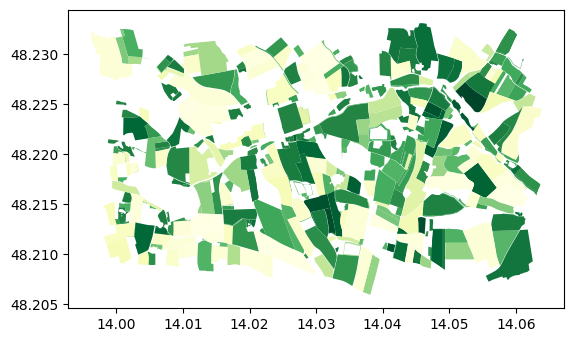

In [69]:
croptypes_ndvi_gdf.plot("ndvi_2020_04_05", cmap='YlGn');

C:\Users\aleks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


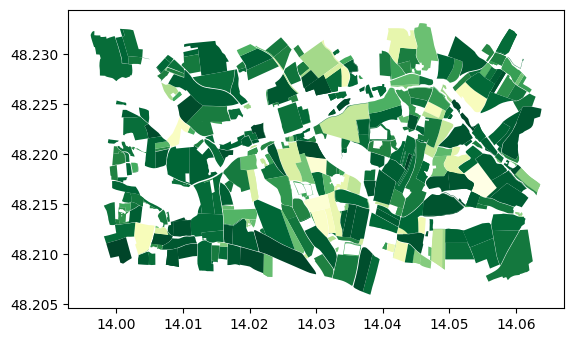

In [70]:
croptypes_ndvi_gdf.plot("ndvi_2020_06_27", cmap='YlGn');

## 7. Time-series processing
* Generate a daily time-series of NDVI values for each pixel by fitting a savitzgy golay smoother to the previously generated, irregular NDVI time-series.

In [71]:
# coming back to the created time-series 
ndvi_dataarray_cp

<xarray.DataArray 's2_ts' (time: 7, lat: 164, lon: 491)>
array([[[0.12056075, 0.11293041, 0.12882839, ..., 0.61330645,
         0.62097087, 0.66601179],
        [0.11164466, 0.11177347, 0.12663317, ..., 0.49399586,
         0.51344937, 0.57924605],
        [0.11827447, 0.11688312, 0.12239961, ..., 0.50353179,
         0.50921659, 0.54008035],
        ...,
        [0.20901275, 0.23688201, 0.22828406, ..., 0.7474373 ,
         0.7474373 , 0.7369727 ],
        [0.20687679, 0.22026826, 0.22303922, ..., 0.69040248,
         0.69040248, 0.681369  ],
        [0.2301542 , 0.23708296, 0.22920407, ..., 0.70192525,
         0.69083447, 0.66335719]],

       [[0.11235955, 0.11820084, 0.12886049, ..., 0.62781713,
         0.67550637, 0.71260751],
        [0.12242798, 0.13233725, 0.12593383, ..., 0.545898  ,
         0.58632627, 0.63382664],
        [0.13850837, 0.13149523, 0.13336793, ..., 0.55902778,
         0.58061821, 0.60944295],
...
        [0.91352951, 0.91229236, 0.91540303, ..., 0.8300057 ,
         0.8300057 , 0.82744158],
        [0.91192479, 0.90916598, 0.91257006, ..., 0.79910998,
         0.79910998, 0.77702243],
        [0.91141451, 0.90329597, 0.9024055 , ..., 0.81354879,
         0.81692356, 0.80058083]],

       [[0.92222222, 0.92311706, 0.90764892, ..., 0.68294314,
         0.65386353, 0.56855658],
        [0.92482245, 0.92049775, 0.91219512, ..., 0.47298199,
         0.40029112, 0.57486137],
        [0.92772735, 0.92372157, 0.91585761, ..., 0.42377179,
         0.35729239, 0.5159129 ],
        ...,
        [0.93192404, 0.93088783, 0.9329806 , ..., 0.19859739,
         0.19859739, 0.19148936],
        [0.93039773, 0.93005503, 0.93006005, ..., 0.20205832,
         0.20205832, 0.20834807],
        [0.93346242, 0.93064799, 0.92890912, ..., 0.22536287,
         0.24192277, 0.23309467]]])
Coordinates:
  * lon          (lon) float64 14.0 14.0 14.0 14.0 ... 14.06 14.06 14.06 14.06
  * lat          (lat) float64 48.23 48.23 48.23 48.23 ... 48.21 48.21 48.21
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-04-05 2020-04-08 ... 2020-08-01

In [72]:
# upsampling the time dimension and interpolating values linearly
ndvi_da_1d = ndvi_dataarray_cp.resample(time = '1D').interpolate("linear")

In [73]:
ndvi_da_1d

<xarray.DataArray 's2_ts' (time: 119, lat: 164, lon: 491)>
array([[[0.12056075, 0.11293041, 0.12882839, ..., 0.61330645,
         0.62097087, 0.66601179],
        [0.11164466, 0.11177347, 0.12663317, ..., 0.49399586,
         0.51344937, 0.57924605],
        [0.11827447, 0.11688312, 0.12239961, ..., 0.50353179,
         0.50921659, 0.54008035],
        ...,
        [0.20901275, 0.23688201, 0.22828406, ..., 0.7474373 ,
         0.7474373 , 0.7369727 ],
        [0.20687679, 0.22026826, 0.22303922, ..., 0.69040248,
         0.69040248, 0.681369  ],
        [0.2301542 , 0.23708296, 0.22920407, ..., 0.70192525,
         0.69083447, 0.66335719]],

       [[0.11782702, 0.11468722, 0.12883909, ..., 0.61814334,
         0.63914937, 0.6815437 ],
        [0.1152391 , 0.11862806, 0.12640005, ..., 0.51129657,
         0.53774167, 0.59743958],
        [0.12501911, 0.12175382, 0.12605572, ..., 0.52203045,
         0.53301713, 0.56320122],
...
        [0.93139848, 0.93035653, 0.93247838, ..., 0.21663762,
         0.21663762, 0.20965943],
        [0.92986993, 0.9294582 , 0.92956034, ..., 0.21911694,
         0.21911694, 0.22459591],
        [0.93283248, 0.9298665 , 0.92815188, ..., 0.24216818,
         0.25835137, 0.24930856]],

       [[0.92222222, 0.92311706, 0.90764892, ..., 0.68294314,
         0.65386353, 0.56855658],
        [0.92482245, 0.92049775, 0.91219512, ..., 0.47298199,
         0.40029112, 0.57486137],
        [0.92772735, 0.92372157, 0.91585761, ..., 0.42377179,
         0.35729239, 0.5159129 ],
        ...,
        [0.93192404, 0.93088783, 0.9329806 , ..., 0.19859739,
         0.19859739, 0.19148936],
        [0.93039773, 0.93005503, 0.93006005, ..., 0.20205832,
         0.20205832, 0.20834807],
        [0.93346242, 0.93064799, 0.92890912, ..., 0.22536287,
         0.24192277, 0.23309467]]])
Coordinates:
  * lon          (lon) float64 14.0 14.0 14.0 14.0 ... 14.06 14.06 14.06 14.06
  * lat          (lat) float64 48.23 48.23 48.23 48.23 ... 48.21 48.21 48.21
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-04-05 2020-04-06 ... 2020-08-01

In [74]:
def scipy_sg(arr):
    return savgol_filter(arr, window_length=9, polyorder=2)

In [75]:
# applying Savitzky–Golay filter to the data
ndvi_smoothed_da_1d = xr.apply_ufunc(scipy_sg, ndvi_da_1d)

In [76]:
ndvi_smoothed_da_1d

<xarray.DataArray 's2_ts' (time: 119, lat: 164, lon: 491)>
array([[[0.07995147, 0.12196618, 0.17008444, ..., 0.66472286,
         0.64298731, 0.61068451],
        [0.06875868, 0.11541487, 0.16539993, ..., 0.52593389,
         0.52878795, 0.54453035],
        [0.07559446, 0.11181366, 0.15566929, ..., 0.51220275,
         0.51065169, 0.52141081],
        ...,
        [0.21997048, 0.22312346, 0.22455334, ..., 0.75058443,
         0.7454432 , 0.73693119],
        [0.20598498, 0.21676266, 0.22454749, ..., 0.68861048,
         0.68835975, 0.68708928],
        [0.22994624, 0.23286353, 0.2347034 , ..., 0.69733048,
         0.68706397, 0.6704856 ]],

       [[0.07568554, 0.12062066, 0.17165029, ..., 0.67436573,
         0.65594315, 0.62827174],
        [0.07118179, 0.11811394, 0.16905002, ..., 0.54139768,
         0.54732998, 0.56656854],
        [0.08025724, 0.11614058, 0.16035313, ..., 0.52872546,
         0.53172945, 0.54791768],
...
        [0.9313794 , 0.931213  , 0.93106192, ..., 0.21462586,
         0.2142505 , 0.21285237],
        [0.92963727, 0.92984077, 0.93002078, ..., 0.21978535,
         0.22116919, 0.22229184],
        [0.93121958, 0.93053003, 0.9300934 , ..., 0.24509856,
         0.24966839, 0.25428062]],

       [[1.05336697, 0.90483598, 0.76293898, ..., 0.66045723,
         0.63169544, 0.58650845],
        [1.041606  , 0.91754683, 0.79328708, ..., 0.51312308,
         0.49286872, 0.48145406],
        [1.01340726, 0.93757504, 0.84798097, ..., 0.46408901,
         0.4416706 , 0.43217765],
        ...,
        [0.93192513, 0.93172464, 0.93155892, ..., 0.19663796,
         0.19618067, 0.19466636],
        [0.93025077, 0.93037403, 0.9305004 , ..., 0.20262341,
         0.20435011, 0.20587389],
        [0.93199268, 0.93121627, 0.93071622, ..., 0.22851162,
         0.23322331, 0.23796319]]])
Coordinates:
  * lon          (lon) float64 14.0 14.0 14.0 14.0 ... 14.06 14.06 14.06 14.06
  * lat          (lat) float64 48.23 48.23 48.23 48.23 ... 48.21 48.21 48.21
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-04-05 2020-04-06 ... 2020-08-01

In [77]:
sel_point = ndvi_smoothed_da_1d.sel(lon=14.04, lat=48.22, method='nearest')

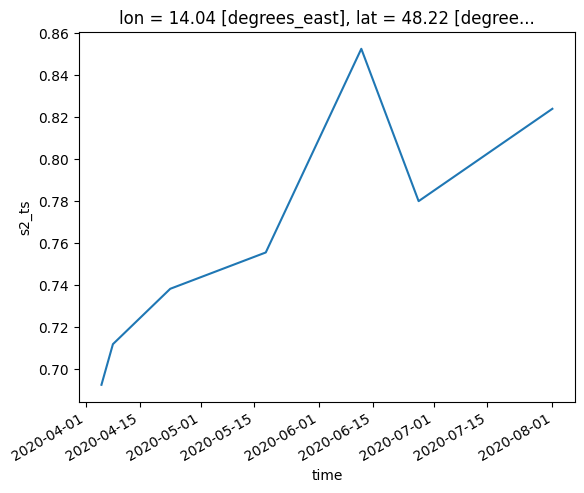

In [78]:
# plotting the resultant values of smoothed NDVI time-series
sel_point.plot();

#### Comments:
- <u>High-quality NDVI time-series:</u> The approach presented above is very basic. More complex algorithms were developed e.g. by Chen J. et al. (2004) [11] or Cao R. et al. (2018) [12]. The second one seems to be suitable for the analyzed task as it addresses *"continuous missing data in the NDVI time series"*.

## 8. CRS transformation:
* Reproject the Sentinel data to an azimuthal equidistant projection centered on the centroid of the bounding box.

In [79]:
s2_ds

<xarray.Dataset>
Dimensions:      (band: 5, time: 16, y: 735, x: 1049)
Coordinates:
  * band         (band) <U8 'B02' 'B04' 'B08' 'B06' 'B11'
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2020-03-19 2020-04-05 ... 2020-09-20
  * x            (x) float64 4.226e+05 4.226e+05 ... 4.331e+05 4.331e+05
  * y            (y) float64 5.345e+06 5.345e+06 ... 5.338e+06 5.338e+06
Data variables:
    s2_ts        (time, band, y, x) float64 dask.array<chunksize=(2, 2, 184, 263), meta=np.ndarray>

In [80]:
s2_da = s2_ds['s2_ts']

In [81]:
# finding the centroid's coordinates
cen_x, cen_y = s2_da.x.min() + 0.5*(s2_da.x.max() - s2_da.x.min()), s2_da.y.min() + 0.5*(s2_da.y.max() - s2_da.y.min())

In [82]:
cen_x.item(), cen_y.item()

(427880.0, 5341490.0)

In [83]:
# defining source CRS
src_crs = Proj("EPSG:32633")

In [84]:
# defining a geographic projection as 'lat_0' & 'lon_0' need to be in degrees 
dst_crs = Proj("EPSG:4326") 

In [85]:
transformer = Transformer.from_proj(src_crs, dst_crs, always_xy=True)

In [86]:
cen_lon, cen_lat = transformer.transform(cen_x.item(), cen_y.item())

In [87]:
# centroid's coordinates in EPSG:4326
cen_lon, cen_lat

(14.02899733397553, 48.22253230327998)

In [88]:
# defining Azimuthal Equidistant projection
aeqd_proj = Proj(proj="aeqd", lon_0=cen_lon, lat_0=cen_lat)

In [89]:
transformer_aeqd = Transformer.from_proj(src_crs, aeqd_proj)

In [90]:
# creating a copy of original xr.DataArray's coordinates
xv, yv = np.meshgrid(s2_da.x, s2_da.y)

In [91]:
# transforming coordinates to Azimuthal Equidistant projection (following [14])
x_aeqd, y_aeqd = transformer_aeqd.transform(xv, yv)

In [92]:
# inserting new coordinates to xr.DataArray
s2_da.coords['x_aeqd'] = (('y', 'x'), x_aeqd)
s2_da.coords['y_aeqd'] = (('y', 'x'), y_aeqd)

In [93]:
# inserting info about crs to xr.DataArray
s2_da.attrs['crs']  = '+proj=aeqd'

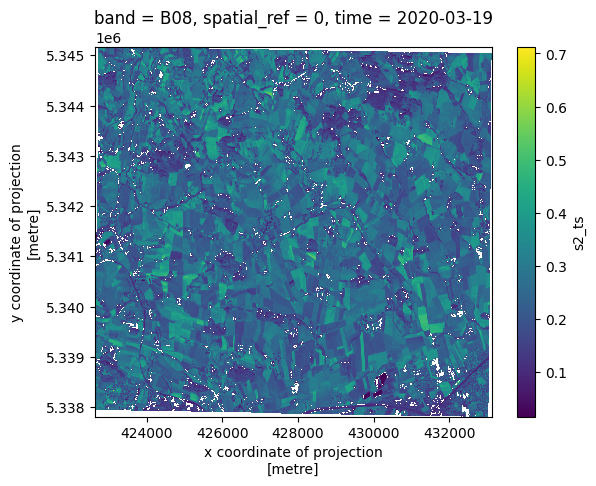

In [94]:
s2_da.sel(band='B08', time='2020-03-19').plot();

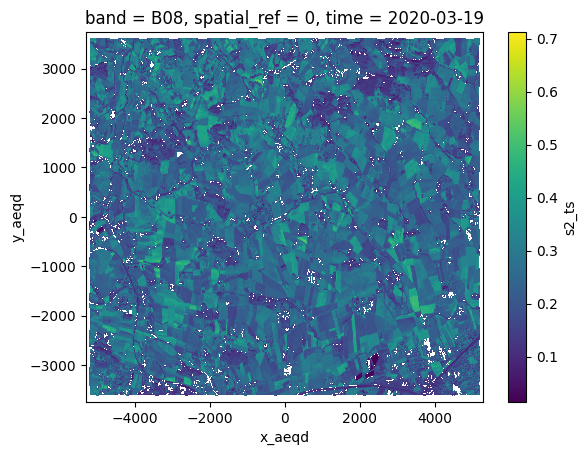

In [95]:
s2_da.sel(band='B08', time='2020-03-19').plot(x="x_aeqd", y="y_aeqd");

#### Sources: 
[1] https://pystac.readthedocs.io/en/stable/tutorials/how-to-create-stac-catalogs.html <br>
[2] https://github.com/radiantearth/stac-spec/blob/master/best-practices.md#common-media-types-in-stac <br>
[3] https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#media-type-for-stac-item <br>
[4] https://stacspec.org/en/about/tools-resources/ <br>
[5] https://github.com/stac-utils/xstac <br>
[6] https://github.com/CS-SI/eodag <br>
[7] http://www.brianmcgill.org/postgis_zonal.pdf <br>
[8] https://pystac.readthedocs.io/en/stable/api/extensions/eo.html#pystac.extensions.eo.EOExtension <br>
[9] https://pystac.readthedocs.io/en/stable/api/pystac.html# <br>
[10] https://dask-geopandas.readthedocs.io/en/stable/index.html <br>
[11] Chen J.; Jönsson P.; Tamura M.; Gu Z.; Matsushita B.; Eklundh L. A simple method for reconstructing a high-quality NDVI time-series data set based on the Savitzky–Golay filter. Remote Sens. Environ. 2004. https://doi.org/10.1016/j.rse.2004.03.014 <br>
[12] Cao R.; Chen Y.; Shen M.; Chen J.; Zhou J.; Wang C.; Yang W. A simple method to improve the quality of NDVI time-series data by integrating spatiotemporal information with the Savitzky-Golay filter. Remote Sens. Environ. 2018. https://doi.org/10.1016/j.rse.2018.08.022 <br>
[13] https://proj4.org/en/9.3/operations/projections/aeqd.html <br>
[14] https://www.linkedin.com/pulse/reproject-xarray-dataset-pyproj-chonghua-yin/